In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.DBLP import DBLP
from Data.Citeseer import Citeseer

import dgl.function as fn
import torch
import numpy as np
import torch_geometric
torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:

dataset = Citeseer() 
original_graph = dataset.load_graph(n_components=30)
device= "cuda:0"
original_graph = original_graph.to(device)


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b

In [48]:
import pickle
def plot_scatter(file, cca=None,is_add=True, save_path=None):
    with open(file, 'rb') as fh:
        coarsener = pickle.load(fh) 
    sum_graph = coarsener.summarized_graph
    sum_graph.nodes["paper"].data.keys()
    X = sum_graph.nodes["paper"].data["feat_pca"]
    Y = sum_graph.nodes["paper"].data["hcites"]
    du = sum_graph.nodes["paper"].data[f"deg_cites"]
    
    if is_add:
        R = X + Y
    else:
        if cca:
            X_c, Y_c = cca.transform(X,Y)
        else:
            X_c, Y_c = coarsener.ccas["cites"].transform(X,Y)
        
        R = X_c / du.unsqueeze(-1) + Y_c
    
    print(du.unsqueeze(-1).shape)
    print(R.shape)
    import torch
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    # Example data
    data = R.cpu()
    mapping = coarsener.get_mapping('paper')
    labels_dict = coarsener.get_labels(mapping, 'paper')
    size = max(labels_dict.keys()) + 1

    # Create a tensor of zeros
    labels = torch.zeros(size, dtype=torch.int64)

    # Fill the tensor with the dictionary values at the corresponding indices
    for idx, value in labels_dict.items():
        labels[idx] = value

    # Create a tensor of zeros
    

    data_np = data.numpy()

    # Perform PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data_np)  # Shape: (3652, 2)
    sizes = [5, 5, 5, 5]
    # Plot with color by label
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.7, sizes=sizes)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Embedding")
    plt.grid(True)
 #   plt.colorbar(scatter, label='Label')
    if save_path:
        plt.savefig(save_path)
    plt.show()
    

torch.Size([3321, 1])
torch.Size([3321, 10])


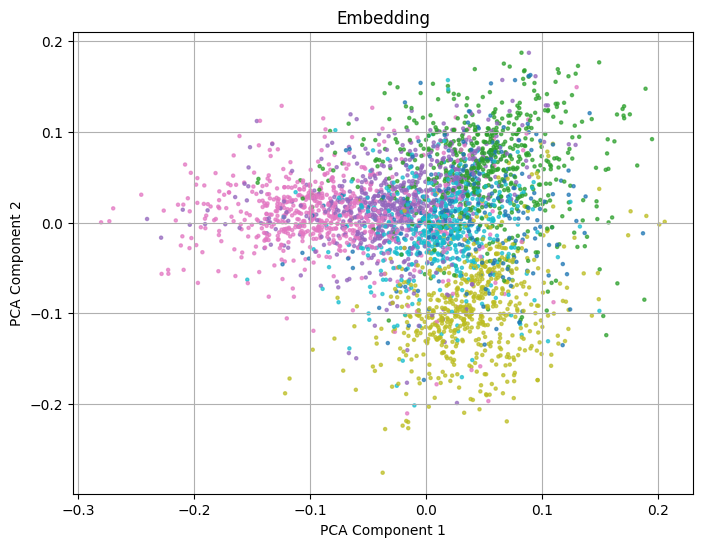

torch.Size([1663, 1])
torch.Size([1663, 10])


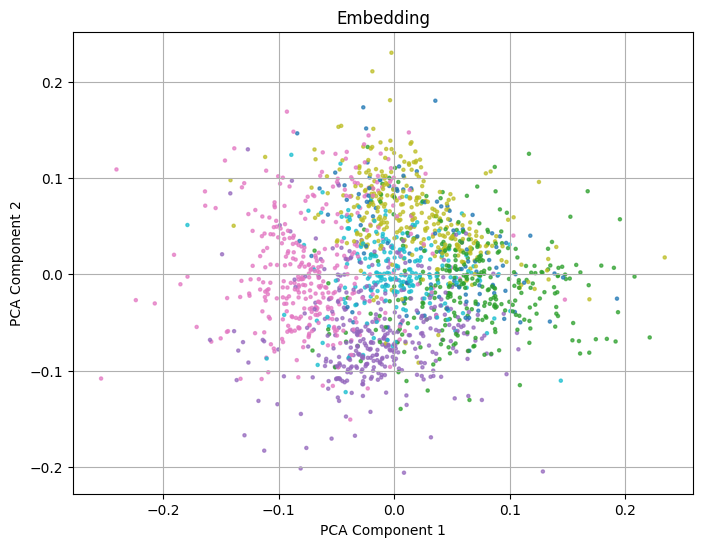

torch.Size([31, 1])
torch.Size([31, 10])


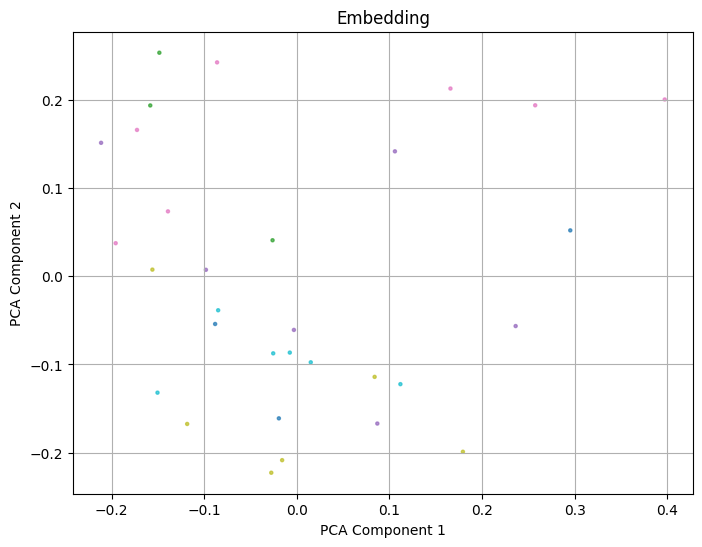

torch.Size([3321, 1])
torch.Size([3321, 3703])


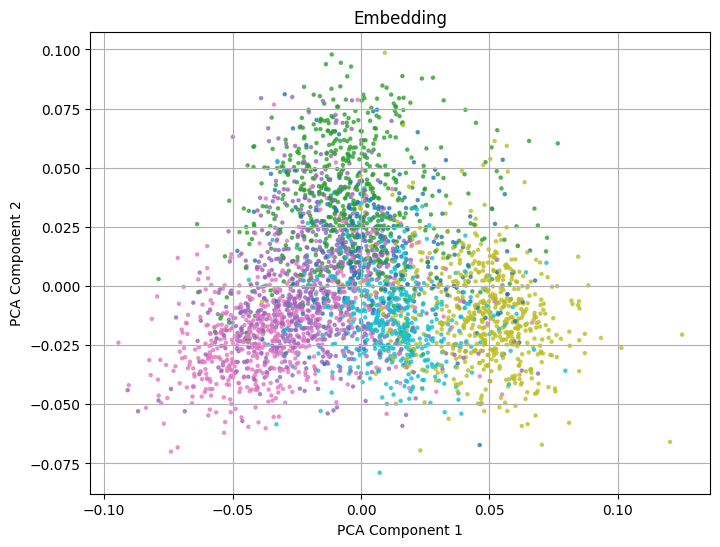

torch.Size([1659, 1])
torch.Size([1659, 3703])


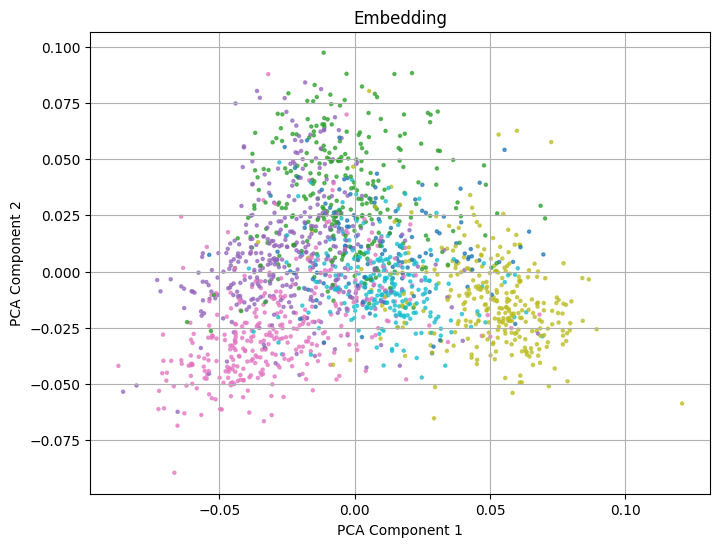

torch.Size([328, 1])
torch.Size([328, 3703])


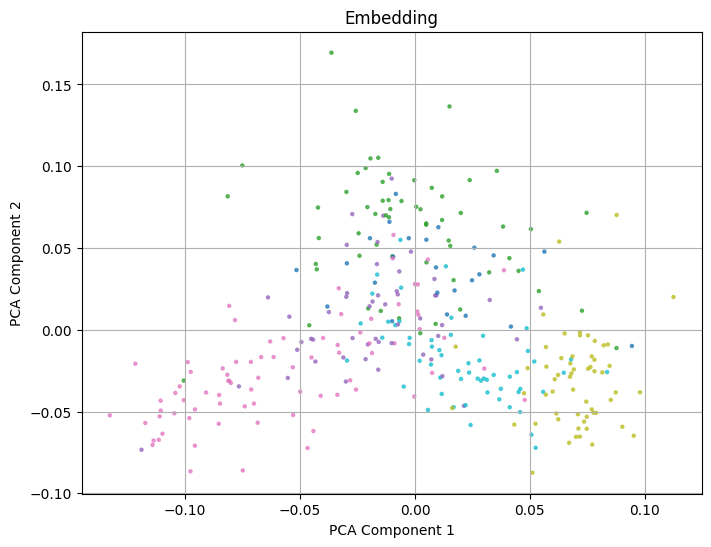

In [52]:
plot_scatter('results/cit_clnl_pca_10/1.0',is_add=False,save_path="plots/scatter_cl_1")
plot_scatter('results/cit_clnl_pca_10/0.5', is_add=False,save_path="plots/scatter_cl_05")
plot_scatter('results/cit_clnl_pca_10/0.01',is_add=False,save_path="plots/scatter_cl_001")
plot_scatter('results/cit_convmatch_metrics/1.0', is_add=True,save_path="plots/scatter_conv_10")
plot_scatter('results/cit_convmatch_metrics/0.5',is_add=True,save_path="plots/scatter_conv_05")
plot_scatter('results/cit_convmatch_metrics/0.1', is_add=True, save_path="plots/scatter_onv_01")

In [55]:
import matplotlib.pyplot as plt

import pickle
def plot_bar(file, save_path=None):
    with open(file, 'rb') as fh:
        coarsener_new = pickle.load(fh) 
    original_graph = coarsener_new.original_graph
    sum_graph = coarsener_new.summarized_graph
    sum_graph.nodes["paper"].data.keys()
    
    # Example data
    
    
    # print(sum_graph.nodes["paper"].data["label"])
    
    # print(torch.sum(torch.bincount(original_graph.nodes["paper"].data["label"].to('cpu'))))
    # print(torch.bincount(sum_graph.nodes["paper"].data["label"].to('cpu')))
    
    mapping = coarsener_new.get_mapping('paper')
    labels = coarsener_new.get_labels(mapping, 'paper')
    size = max(labels.keys()) + 1

    # Create a tensor of zeros
    label_tensor = torch.zeros(size, dtype=torch.int64)

    # Fill the tensor with the dictionary values at the corresponding indices
    for idx, value in labels.items():
        label_tensor[idx] = value
    
    base_heights = torch.bincount(original_graph.nodes["paper"].data["label"].to('cpu'))    # Bottom (larger) bars
    top_heights = torch.bincount(label_tensor)    # Top (smaller) bars
    print(base_heights)
    print(top_heights)
    
    cmap = plt.get_cmap('tab10')
    labels = ['A', 'B', 'C', 'D', 'E', 'F']
    x = range(len(labels))

    # Plot bars using a loop
    for i in x:
        color = cmap(i % 10)  # Get color from tab10
        # Plot bottom (original graph) bar
        plt.bar(i, base_heights[i], color=color, alpha=0.3, label='Original' if i == 0 else "")
        # Plot top (summarized graph) bar stacked on top
        plt.bar(i, top_heights[i], color=color, alpha=1.0, label='Summarized' if i == 0 else "")

    # Add labels
    plt.xticks(x, labels)
    plt.ylabel('Count')
    plt.title('Number of nodes per label before and after reduction')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

#     # Add labels
#     plt.xticks(x, labels)
#     plt.ylabel('Height')
#     plt.title('Stacked Bar Plot (Top Smaller) ')

#     plt.show()
#  #   plt.colorbar(scatter, label='Label')
#     if save_path:
#         plt.savefig(save_path)
#     plt.show()



In [26]:
with open('results/cit_clnl_pca_10/0.5', 'rb') as fh:
        coarsener_new = pickle.load(fh) 
print(torch.bincount(coarsener_new.original_graph.nodes["paper"].data["label"].to('cpu')))
    


tensor([264, 590, 668, 701, 596, 508])


tensor([264, 590, 668, 701, 596, 508])
tensor([112, 310, 355, 361, 313, 212])


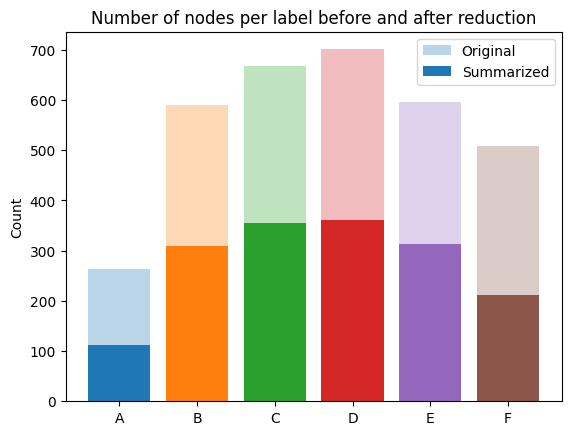

tensor([264, 590, 668, 701, 596, 508])
tensor([23, 71, 47, 84, 57, 49])


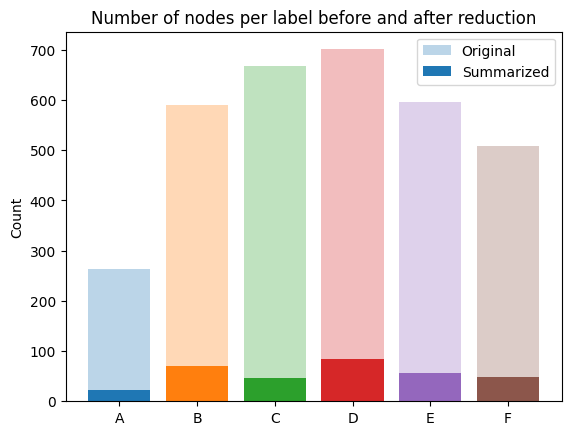

In [58]:
plot_bar( 'results/cit_clnl_pca_10/0.5', save_path="plots/bar_cl_05")
plot_bar( 'results/cit_clnl_pca_10/0.1', save_path="plots/bar_cl_01")

tensor([264, 590, 668, 701, 596, 508])
tensor([124, 279, 365, 348, 301, 242])


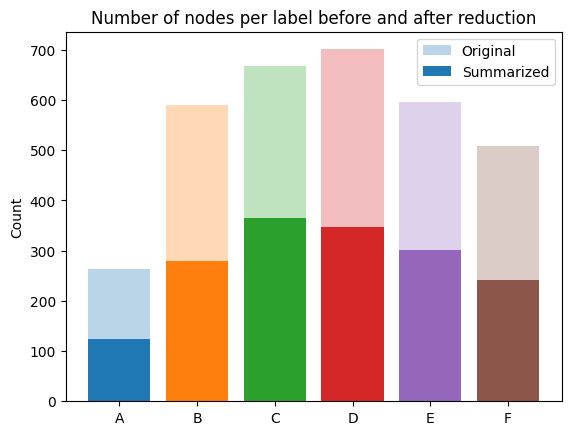

tensor([264, 590, 668, 701, 596, 508])
tensor([24, 60, 50, 78, 58, 58])


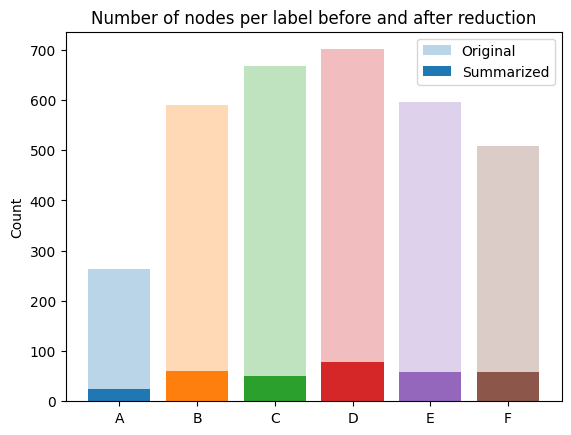

In [ ]:
plot_bar( 'results/cit_convmatch_metrics/0.5', save_path="plots/bar_conv_05")
plot_bar( 'results/cit_convmatch_metrics/0.1', save_path="plots/bar_conv_01")



In [13]:
plot_bar('results/cit_convmatch_metrics/0.5')

FileNotFoundError: [Errno 2] No such file or directory: 'results/cit_convmatch_metrics/0.5'

/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b

Epoch 1/500, Loss: 49.7149
Epoch 2/500, Loss: 47.9807
Epoch 3/500, Loss: 47.7365
Epoch 4/500, Loss: 47.7023
Epoch 5/500, Loss: 47.6836
Epoch 6/500, Loss: 47.6711
Epoch 7/500, Loss: 47.6672
Epoch 8/500, Loss: 47.6651
Epoch 9/500, Loss: 47.6640
Epoch 10/500, Loss: 47.6633
Epoch 11/500, Loss: 47.6631
Epoch 12/500, Loss: 47.6630
Epoch 13/500, Loss: 47.6629
Epoch 14/500, Loss: 47.6629
Epoch 15/500, Loss: 47.6629
Epoch 16/500, Loss: 47.6628
Epoch 17/500, Loss: 47.6628
Epoch 18/500, Loss: 47.6628
Epoch 19/500, Loss: 47.6628
Epoch 20/500, Loss: 47.6628
Epoch 21/500, Loss: 47.6628
Epoch 22/500, Loss: 47.6628
Epoch 23/500, Loss: 47.6627
Epoch 24/500, Loss: 47.6627
Epoch 25/500, Loss: 47.6627
Epoch 26/500, Loss: 47.6627
Epoch 27/500, Loss: 47.6626
Epoch 28/500, Loss: 47.6626
Epoch 29/500, Loss: 47.6625
Epoch 30/500, Loss: 47.6625
Epoch 31/500, Loss: 47.6624
Epoch 32/500, Loss: 47.6623
Epoch 33/500, Loss: 47.6621
Epoch 34/500, Loss: 47.6619
Epoch 35/500, Loss: 47.6615
Epoch 36/500, Loss: 47.6611
E

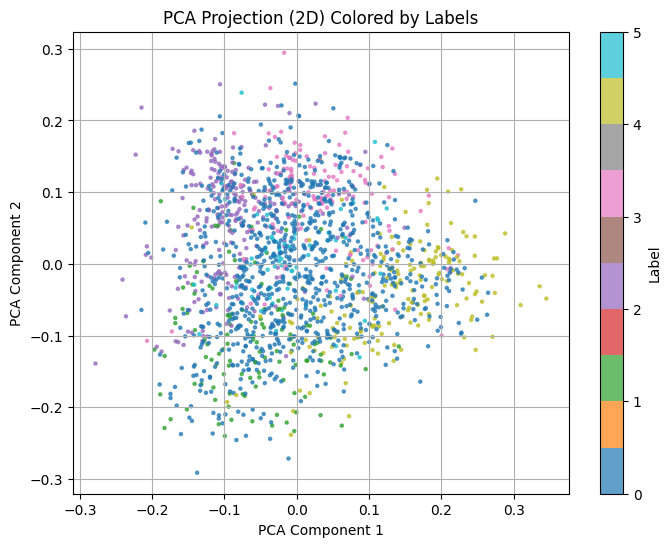

In [52]:
import pickle
with open(f'results/cit_cl_pca_10/0.5', 'rb') as fh:
    coarsener = pickle.load(fh) 
with open(f'results/cit_cl_pca_10/0.99', 'rb') as fh:
    coarsener_begin = pickle.load(fh) 
sum_graph = coarsener.summarized_graph
sum_graph.nodes["paper"].data.keys()
X = sum_graph.nodes["paper"].data["feat_pca"]
Y = sum_graph.nodes["paper"].data["hcites"]

from Projections.ContrastiveLearner import ContrastiveLearner
cl = ContrastiveLearner(X.shape[1], Y.shape[1])
orig_graph = coarsener_begin.summarized_graph

X_sum = orig_graph.nodes["paper"].data["feat_pca"]
Y_sum = orig_graph.nodes["paper"].data["hcites"]

#cl.fit(X,Y)
cl.fit(X_sum, Y_sum)

X_c, Y_c = coarsener.ccas["cites"].transform(X,Y)

du = sum_graph.nodes["paper"].data[f"deg_cites"]
print(du.unsqueeze(-1).shape)
R = X_c / du.unsqueeze(-1) + Y_c
print(R.shape)
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Example data
data = R.cpu()
labels =sum_graph.nodes["paper"].data["label"].cpu()

# Get the first two dimensions

data_np = data.numpy()

# Perform PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(data_np)  # Shape: (3652, 2)
sizes = [5, 5, 5, 5]
# Plot with color by label
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.7, sizes=sizes)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection (2D) Colored by Labels")
plt.grid(True)
plt.colorbar(scatter, label='Label')
plt.show()

/home/robin/thesis/hetero-conv-matching/.venv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b

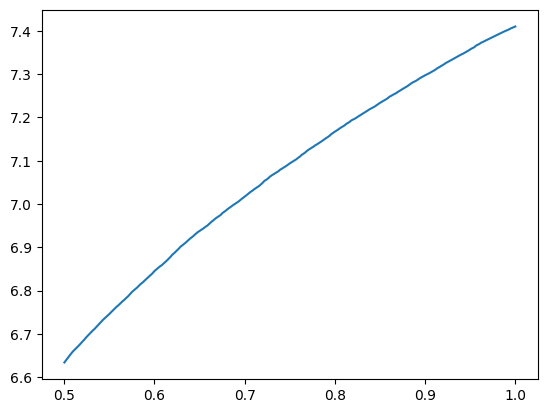

In [80]:
import matplotlib.pyplot as plt
import torch
with open(f'results/cit_cl_pca_10/0.5', 'rb') as fh:
    coarsener = pickle.load(fh) 
ratios = coarsener.metrics['r'][:-1]
thetas = [v.cpu() for v in coarsener.metrics['theta']['cites']]

plt.plot(ratios, thetas)